In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lib.fit_model_on_multiple import fit_lr, predict_lr, fit_rf, plot_md_vs_rmsd, predict_rf
from pathlib import Path
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from scipy.stats import linregress, pearsonr
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [185]:
results = []
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence('T1053-D1', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,2,4,8], mode='full_window')

da.load_results()

Initializing T1053-D1 ...
Results already exist
Casp ID: T1053-D1 	PDB: 7m7a
Structure exists: 'pdb/pdb7m7a.ent' 
UniProt ID: Q5ZRA8


In [186]:
from lib.across_window_utils import (
    get_phi_psi_dist_window,
    get_xrays_window,
    get_afs_window,
    get_preds_window,
    precompute_dists,
    find_clusters,
    filter_precomputed_dists,
    calc_da_for_one_window,
    calc_da_window,
    get_cluster_medoid,
    get_target_cluster_icov,
    get_combined_phi_psi_dist
)
from lib.utils import get_phi_psi_dist

In [187]:
from matplotlib.patches import ConnectionPatch

def plot(q, seq_ctxt, xrays, afs, clusters, phi_psi_dist, precomputed_dists):
    n_cluster_plot = 10
    n_clusters = len(np.unique(clusters))
    xrays = xrays.reshape(2, -1)
    afs = afs.reshape(2, -1)
    print(pd.Series(clusters).value_counts())

    cluster_points = phi_psi_dist.groupby(clusters).count().sort_values('phi_0', ascending=False).index.values
    clusters_plot = cluster_points[:n_cluster_plot]
    medoids = []
    for cluster in cluster_points:
        medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, clusters, cluster)
        medoids.append(medoid)
    medoids = np.array(medoids)

    colors = sns.color_palette('Dark2', n_clusters)
    fig, axes = plt.subplots(len(clusters_plot), q.winsize, figsize=(16, min(n_cluster_plot, len(clusters_plot))*4), sharey=True, sharex=True)
    for i,axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            cluster_dist = phi_psi_dist[clusters == clusters_plot[i]]

            sns.scatterplot(data=phi_psi_dist[clusters != clusters_plot[i]], x=f'phi_{j}', y=f'psi_{j}', ax=ax, label='Other Clusters', color='tab:blue', alpha=0.5)
            sns.scatterplot(data=cluster_dist, x=f'phi_{j}', y=f'psi_{j}', ax=ax, label=f'Cluster {clusters_plot[i]}', color=colors[i])
            ax.scatter(xrays[0,j], xrays[1,j], color='tab:red', marker='X', label='X-ray', zorder=1000)
            ax.scatter(afs[0,j], afs[1,j], color='tab:orange', marker='X', label='AF', zorder=1000)
            # ax.scatter(pred[0,j], pred[1,j], color='tab:orange', marker='X', label=pred_id, zorder=1000)
            ax.scatter(medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j], color='black', marker='X', label='Cluster Centroid', zorder=1000)

            def add_conn(xyA, xyB, color, lw, **kwargs):
                con = ConnectionPatch(
                    xyA=xyA, 
                    xyB=xyB, 
                    coordsA="data", coordsB="data", 
                    axesA=axrow[j], axesB=axrow[j+1], 
                    color=color, lw=lw, linestyle='--', alpha=0.5, **kwargs
                )
                fig.add_artist(con)
            if j < q.winsize - 1:
                # TODO draw lines for 50 points closest to centroid
                for k, row in cluster_dist.sample(min(cluster_dist.shape[0], 50)).iterrows():
                    add_conn((row[f'phi_{j}'], row[f'psi_{j}']), (row[f'phi_{j+1}'], row[f'psi_{j+1}']), colors[i], 1)
                add_conn((xrays[0,j], xrays[1,j]), (xrays[0,j+1], xrays[1,j+1]), 'tab:red', 5, zorder=100)
                add_conn((afs[0,j], afs[1,j]), (afs[0,j+1], afs[1,j+1]), 'tab:orange', 5, zorder=100)
                # add_conn((pred[0,j], pred[1,j]), (pred[0,j+1], pred[1,j+1]), 'tab:orange', 5, zorder=100)
                add_conn((medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j]), (medoids[i].reshape(2,-1)[0,j+1], medoids[i].reshape(2,-1)[1,j+1]), 'black', 5, zorder=100)

            ax.set_xlim(-180, 180)
            ax.set_ylim(-180, 180)
            ax.set_xlabel('')
            if j == q.winsize - 1:
                ax.legend()
            else:
                ax.legend().remove()
            if j == 0:
                ax.set_ylabel(f'Cluster {clusters_plot[i]} [{cluster_dist.shape[0]}]')
    fig.supxlabel('Phi')
    fig.supylabel('Psi')
    # fig.suptitle(
    #     # f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}: N={n_points} Silhouette Score: {sil_score:.2f}, X-ray Score [Cluster {nearest_cluster}]: {xray_sil:.2f}, Prediction Score [Cluster {nearest_cluster_pred}]: {pred_sil:.2f}', 
    #     f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}: N={n_points} ({n_unassigned} unassigned) Silhouette Score: {sil_score:.2f}, X-ray Score [Cluster {nearest_cluster}]: {xray_maha:.2f}', 
    #     y=1.01
    # )
    plt.tight_layout()
    plt.show()

In [188]:
def plot_simple(q, phi_psi_dist, clusters=None, xrays=None, c=None):
    fig, axes = plt.subplots(1,q.winsize, figsize=(q.winsize*4,5))
    if xrays is not None:
        xrays = xrays.reshape(2, -1)
    phi_psi_dist_points = phi_psi_dist.values.reshape(phi_psi_dist.shape[0], 2, -1)
    for i in range(q.winsize):
        axes[i].scatter(phi_psi_dist_points[:,0,i], phi_psi_dist_points[:,1,i], marker='.')
        if c is not None:
            axes[i].scatter(phi_psi_dist_points[clusters==c,0,i], phi_psi_dist_points[clusters==c,1,i], c='orange', zorder=5)
        if xrays is not None:
            axes[i].scatter(xrays[0,i], xrays[1,i], c='r', marker='X', zorder=10, s=100)
        axes[i].set_xlim(-180,180)
        axes[i].set_ylim(-180,180)
    plt.show()

In [200]:
MIN_SAMPLES = [100, 20, 1, 1]
MIN_CLUSTER_SIZES = [20, 5, 1, 1]
METRICS = ['maha', 'euclidean', 'euclidean', 'euclidean']
all_n_clusters = []
def get_da_for_all_predictions_window_(ins):
    ins.phi_psi_predictions['da'] = np.nan
    ins.phi_psi_predictions['n_samples'] = np.nan
    ins.phi_psi_predictions['n_samples_list'] = ''
    ins.xray_phi_psi['da'] = np.nan
    ins.xray_phi_psi['n_samples'] = np.nan
    ins.xray_phi_psi['n_samples_list'] = ''

    center_idx_ctxt = ins.queries[-1].get_center_idx_pos()
    winsize_ctxt = ins.queries[-1].winsize
    seqs_for_window = ins.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

    for i,seq_ctxt in enumerate(seqs_for_window):
        print(f'{i}/{len(ins.xray_phi_psi.seq_ctxt.unique())-1}: {seq_ctxt}')
        if 'X' in seq_ctxt:
            print(f'\tSkipping {seq_ctxt} - X in sequence')
            continue

        _, info = get_phi_psi_dist(ins.queries, seq_ctxt)
        for i in info:
            print(f'\tWin {i[0]}: {i[1]} - {i[2]} samples')

        # TODO n_samples

        q = ins.queries[0]
        xrays = get_xrays_window(ins, q, seq_ctxt)
        preds = get_preds_window(ins, q, seq_ctxt)
        afs = get_afs_window(ins, q, seq_ctxt)

        if xrays.shape[0] != q.winsize*2:
            print(f"Xray data for {seq_ctxt} is incomplete")
            continue
        if preds is None or preds.shape[0] == 0:
            print(f"No predictions for {seq_ctxt}")
            continue
        if afs is None or afs.shape[0] != q.winsize*2:
            print(f"AF data for {seq_ctxt} is incomplete")
            continue

        phi_psi_dist, phi_psi_dist_v = get_combined_phi_psi_dist(da, seq_ctxt)
        if phi_psi_dist.shape[0] == 0:
            print(f"No pdbmine data for {seq_ctxt}")
            continue
        if phi_psi_dist.shape[0] < MIN_SAMPLES[0]:
            print(f"Not enough pdbmine data for {seq_ctxt}")
            continue

        precomputed_dists = precompute_dists(phi_psi_dist_v)
        n_clusters, clusters = find_clusters(precomputed_dists, MIN_CLUSTER_SIZES[0])
        if n_clusters == 0:
            print(f"No clusters found for {seq_ctxt}")
            continue
        precomputed_dists, phi_psi_dist_v, clusters = filter_precomputed_dists(precomputed_dists, phi_psi_dist_v, clusters)
        target_cluster, target, icov = get_target_cluster_icov(phi_psi_dist_v, precomputed_dists, clusters, afs)
        if icov is None:
            print(f"Error calculating mahalanobis distance for {seq_ctxt}")
            continue

        # TODO other winsizes - find medoid in those dimensions
        xray_maha = calc_da_for_one_window(xrays, target, icov)
        preds_maha = calc_da_window(preds, target, icov)

        print(f'\t{i}: {xray_maha:.2f}, {np.nanmean(preds_maha):.2f}')
        all_n_clusters.append(n_clusters)

        col_name = f'da'
        ins.xray_phi_psi.loc[ins.xray_phi_psi.seq_ctxt == seq_ctxt, col_name] = xray_maha

        view = ins.phi_psi_predictions.loc[ins.phi_psi_predictions.seq_ctxt == seq_ctxt].reset_index().set_index('protein_id')
        view.loc[preds.index, col_name] = preds_maha
        ins.phi_psi_predictions.loc[view['index'], col_name] = view.set_index('index')[col_name]

        # plot_simple(q, phi_psi_dist_v, clusters, xrays, target_cluster)
        # plot(ins.queries[0], seq_ctxt, xrays, afs, clusters, phi_psi_dist_v, precomputed_dists)

get_da_for_all_predictions_window_(da)
da._get_grouped_preds()

0/343: KKALKES
	Win 4: ALKE - 9534 samples
	Win 5: KALKE - 1331 samples
	Win 6: KALKES - 16 samples
	Win 7: KKALKES - 0 samples
	(7, 'KKALKES', 0, 8): 9.86, 29.62
1/343: KALKESQ
	Win 4: LKES - 5803 samples
	Win 5: ALKES - 621 samples
	Win 6: ALKESQ - 21 samples
	Win 7: KALKESQ - 0 samples
	(7, 'KALKESQ', 0, 8): 2.00, 8.78
2/343: ALKESQL
	Win 4: KESQ - 1670 samples
	Win 5: LKESQ - 490 samples
	Win 6: LKESQL - 273 samples
	Win 7: ALKESQL - 0 samples
	(7, 'ALKESQL', 0, 8): 1.70, 8.39
3/343: LKESQLQ
	Win 4: ESQL - 2175 samples
	Win 5: KESQL - 304 samples
	Win 6: KESQLQ - 0 samples
	Win 7: LKESQLQ - 0 samples
	(7, 'LKESQLQ', 0, 8): 2.29, 8.52
4/343: KESQLQF
	Win 4: SQLQ - 1909 samples
	Win 5: ESQLQ - 452 samples
	Win 6: ESQLQF - 0 samples
	Win 7: KESQLQF - 0 samples
	(7, 'KESQLQF', 0, 8): 4.48, 11.70
5/343: ESQLQFL
	Win 4: QLQF - 531 samples
	Win 5: SQLQF - 70 samples
	Win 6: SQLQFL - 0 samples
	Win 7: ESQLQFL - 0 samples
	(7, 'ESQLQFL', 0, 8): 8.10, 11.07
6/343: SQLQFLT
	Win 4: LQFL - 2302

In [174]:
old = da.phi_psi_predictions.copy()

In [93]:
da.phi_psi_predictions = old.copy()

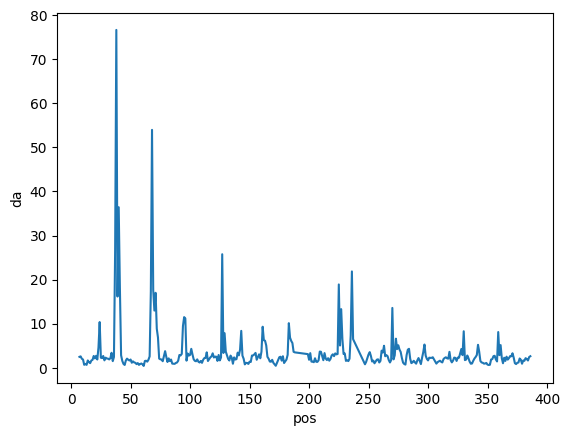

In [182]:
sns.lineplot(pd.read_csv(da.outdir / da.xray_da_fn), x='pos', y='da')
plt.show()

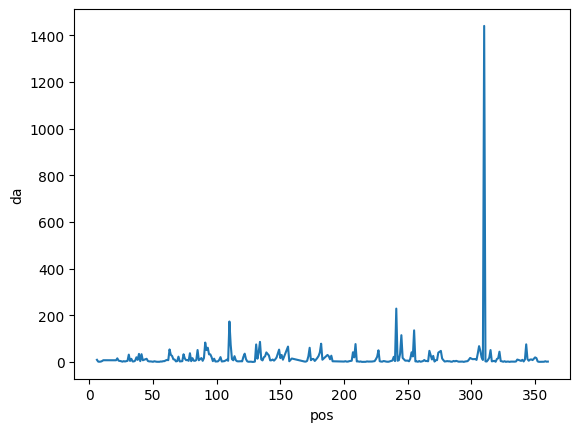

In [201]:
sns.lineplot(da.xray_phi_psi, x='pos', y='da')
plt.show()

In [213]:
w = 1
da.phi_psi_predictions['da'] = (da.phi_psi_predictions['da_0'] * w).add(da.phi_psi_predictions['da_1'] * (1-w), fill_value=0)
da.xray_phi_psi['da'] = (da.xray_phi_psi['da_0'] * w).add(da.xray_phi_psi['da_1'] * (1-w), fill_value=0)
# da.phi_psi_predictions['da'] = da.phi_psi_predictions['da_1']
# da.xray_phi_psi['da'] = da.xray_phi_psi['da_1']
da._get_grouped_preds()

Slope: -92.54283645008127, Intercept: 194.10768924462883 R-squared: 0.7442114108750987


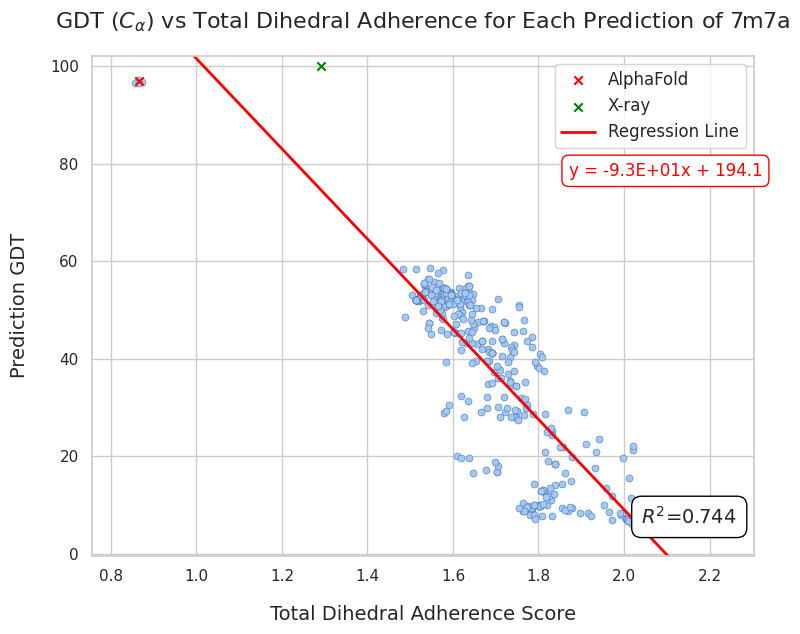

In [209]:
da.filter_nas(0.8)
da.plot_da_vs_gdt_simple()